In [195]:
import numpy as np
from PIL import Image
from sklearn.feature_extraction import image
import matplotlib.pyplot as plt
import colorsys

Investigate the use of non normalized weights 

In [231]:
border = Image.open('border.jpg')
border = border.resize((25,25))
borderColor = np.asarray(border)
borderBW = []
for row in borderColor: 
    newRow = []
    for entry in row: 
        (h,s,v) = colorsys.rgb_to_hsv(entry[0]/255, entry[1]/255, entry[2]/255)
        #newRow.append(0.3*entry[0] + 0.59*entry[1] + 0.11*entry[2])
        newRow.append(h)
    borderBW.append(np.asarray(newRow))
borderBW = np.asarray(borderBW)

In [232]:
borderMask = np.full((25, 25), True)
graph = image.img_to_graph(borderBW, mask = borderMask)
graph.data = np.exp(-graph.data/graph.data.std())
from sklearn.cluster import spectral_clustering
import matplotlib.pyplot as plt

labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
label_im = np.full(borderMask.shape, -1.0)
label_im[borderMask] = labels

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 2 has 2 dimension(s)

In [229]:
graph

<625x625 sparse matrix of type '<class 'numpy.float64'>'
	with 3025 stored elements in COOrdinate format>

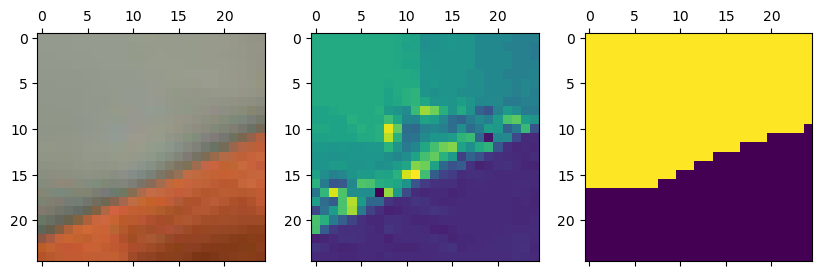

In [230]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
axs[0].matshow(borderColor)
axs[1].matshow(borderBW)
axs[2].matshow(label_im)
plt.show()

In [51]:
# Import images and get black and white and color representation as arrays
coins = Image.open('coins.png')
coinsColor = np.asarray(coins)
coinsBW = []
for row in coinsColor: 
    newRow = []
    for entry in row: 
        newRow.append(0.3*entry[0] + 0.59*entry[1] + 0.11*entry[2])
    coinsBW.append(np.asarray(newRow))
coinsBW = np.asarray(coinsBW)

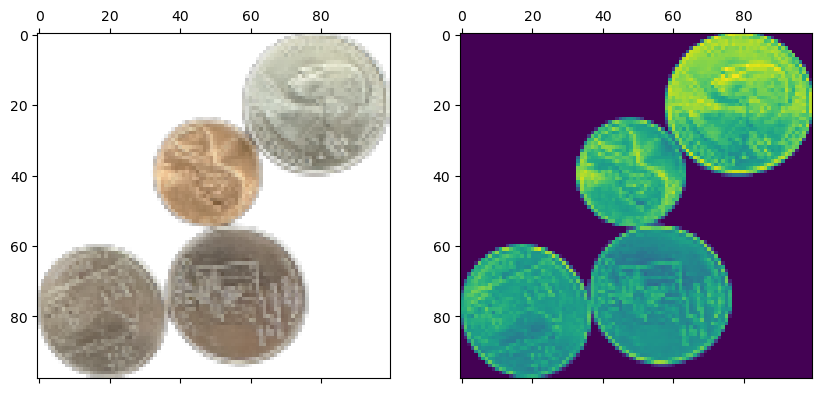

In [221]:
# Display images below
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(coinsColor)
axs[1].matshow(coinsBW)
plt.show()

In [53]:
imgMask = []
for row in coinsColor: 
    newRow = []
    for entry in row: 
        newRow.append(entry[3] > 50)
    imgMask.append(np.asarray(newRow))
imgMask = np.asarray(imgMask)

In [54]:
graph = image.img_to_graph(coinsBW, mask = imgMask)
graph.data = np.exp(-graph.data/graph.data.std())

In [55]:
from sklearn.cluster import spectral_clustering
import matplotlib.pyplot as plt

labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(imgMask.shape, -1.0)
label_im[imgMask] = labels

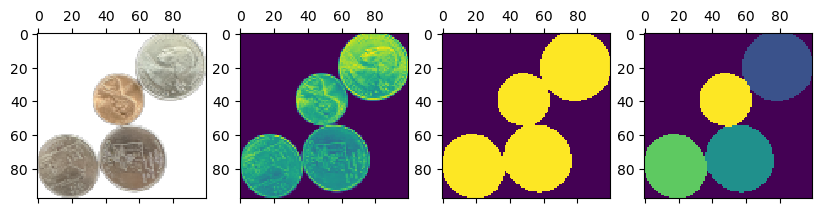

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
axs[0].matshow(coinsColor)
axs[1].matshow(coinsBW)
axs[2].matshow(imgMask)
axs[3].matshow(label_im)
plt.show()

Preliminary results generated from only using black and white images to find the min cut. However, this only relies on the difference in value, black and white so it doesn't account for the difference in color. Since the graph's edges are determined by the difference in pixels, instead of looking at difference in value, look at the difference in color, norm of difference. 

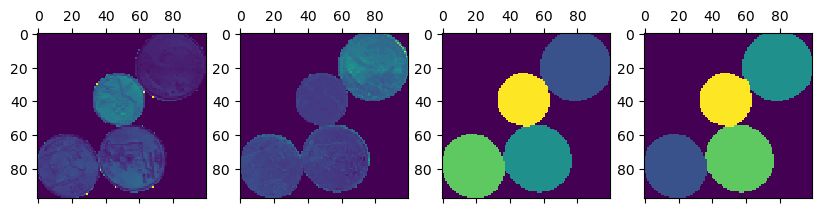

In [223]:

#get only saturation
coinsS = []
coinsH = []
for row in coinsColor: 
    newRowS = []
    newRowH = []
    for entry in row: 
        (h,s,v) = colorsys.rgb_to_hsv(entry[0]/255, entry[1]/255, entry[2]/255)
        newRowS.append(s)
        newRowH.append(h)
    coinsS.append(np.asarray(newRowS))
    coinsH.append(np.asarray(newRowH))
coinsS = np.asarray(coinsS)
coinsH = np.asarray(coinsH)

coinsSGraph = image.img_to_graph(coinsS, mask = imgMask)
coinsHGraph = image.img_to_graph(coinsH, mask = imgMask)
coinsSGraph.data = np.exp(-coinsSGraph.data/graph.data.std())
coinsHGraph.data = np.exp(-coinsHGraph.data/graph.data.std())

labelsS = spectral_clustering(coinsSGraph, n_clusters=4, eigen_solver="arpack")
label_imS = np.full(imgMask.shape, -1.0)
label_imS[imgMask] = labelsS

labelsH = spectral_clustering(coinsHGraph, n_clusters=4, eigen_solver="arpack")
label_imH = np.full(imgMask.shape, -1.0)
label_imH[imgMask] = labelsH

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
axs[0].matshow(coinsS)
axs[1].matshow(coinsH)
axs[2].matshow(label_imS)
axs[3].matshow(label_imH)
plt.show()

In [ ]:
# Generate matrix 
D = np.zeros(shape=(100,100))
W = np.zeros(shape=(100,100))
# loop through all the pixels, determine the Degree matrix 
for x in range(len(borderBW)):
    for y in range(len(borderBW[0])):
        # calcualte the degree 
        d = 0
        d += 1 if y+1 < len(borderBW[0]) else 0
        d += 1 if x+1 < len(borderBW) else 0
        d += 1 if y-1 >= 0 else 0
        d += 1 if x-1 >= 0 else 0
        
        D[x*len(borderBW)+y][x*len(borderBW)+y] = np.float64(d)


# determine the weight matrix 
changes =[]
for x in range(len(borderBW)):
    for y in range(len(borderBW[0])):
        def computeWeight(i, j, a, b): 
            if a >= 0 and a < len(borderBW) and b >= 0 and b < len(borderBW[0]):
                difference = np.abs(borderBW[i][j] - borderBW[a][b])
                W[i*len(borderBW[0])+j][a*len(borderBW[0])+b] = difference
                W[a*len(borderBW[0])+b][i*len(borderBW[0])+j] = difference
        computeWeight(x, y, x+1, y)
        computeWeight(x, y, x, y+1)
        computeWeight(x, y, x-1, y)
        computeWeight(x, y, x, y-1)

stdDev = np.std(W)
print(stdDev)
for x in range(len(W)):
    for y in range(len(W[0])):
        W[x][y] = np.exp(-1*W[x][y]/stdDev)
L = D - W

eigva, eigve = np.linalg.eig(L)
# only care about first two eigve 


#print(eigve)
print(eigva)

from sklearn.cluster import KMeans
X = np.array([eigve[98], eigve[95]])
X = X.transpose()
print(X)
kmeans = KMeans(n_clusters=2, random_state=0, init="random").fit(X)
print(kmeans.labels_)

In [245]:
import scipy as sp

L = [[ 2., -6., 0., 0.], 
     [-6.,  2., 0., 0.], 
     [0., 0.,  2., -6.], 
     [0., 0., -6.,  2.]]
L = np.array(L)

L = np.exp(-L/(L.std()))
print(L)
# compute eigenvectors 
eigva, eigve = sp.linalg.eig(L)
# only care about first two eigve 
print(eigva)
print(eigve)
from sklearn.cluster import KMeans
X = np.array([eigve[0],eigve[1]])
X = X.transpose()

kmeans = KMeans(n_clusters=2, random_state=0, init="random").fit(X)
kmeans.labels_

[[0.51341712 7.3890561  1.         1.        ]
 [7.3890561  0.51341712 1.         1.        ]
 [1.         1.         0.51341712 7.3890561 ]
 [1.         1.         7.3890561  0.51341712]]
[-6.87563898+0.j  5.90247322+0.j  9.90247322+0.j -6.87563898+0.j]
[[ 7.07106781e-01 -5.00000000e-01 -5.00000000e-01  1.00783601e-01]
 [-7.07106781e-01 -5.00000000e-01 -5.00000000e-01 -1.00783601e-01]
 [ 1.38390475e-17  5.00000000e-01 -5.00000000e-01 -6.99887609e-01]
 [ 1.38390475e-17  5.00000000e-01 -5.00000000e-01  6.99887609e-01]]


array([0, 1, 1, 1], dtype=int32)

In [ ]:
L = np.zeros(shape=(100,100))
#L = np.subtract(D, W)
for x in range((100)):
    for y in range((100)):
        L[x][y] = D[x][y]- W[x][y]


labels = spectral_clustering(L, n_clusters=2, eigen_solver="arpack")
label_im = np.full(borderMask.shape, -1.0)
label_im[borderMask] = labels

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
axs[0].matshow(borderColor)
axs[1].matshow(borderBW)
axs[2].matshow(label_im)
plt.show()

ignore stuff above 
Since the imgToGraph only works with non 1D data, rewrite to work with multiple  